# Imports & Configuration

In [ ]:
import SimpleITK as sitk
import numpy as np
import glob
import os
import tifffile
import matplotlib.pyplot as plt
from IPython.display import clear_output
import config


DATA_BASE_PATH = os.path.join(config.DATASPACE, "TMA_Cores_Grouped_NEW")
WORK_OUTPUT= os.path.join(config.DATASPACE, "Registered")
TARGET_CORE = "Core_11" 

INPUT_FOLDER = os.path.join(DATA_BASE_PATH, TARGET_CORE)
OUTPUT_FOLDER =  os.path.join(WORK_OUTPUT, "test")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Get sorted file list
file_list = sorted(glob.glob(os.path.join(INPUT_FOLDER, "*.ome.tif")))
print(f"Target: {TARGET_CORE} | Found {len(file_list)} slices")
print(f"Output: {WORK_OUTPUT} ")



# VISUALIZATION HELPER

In [2]:
def show_live_check(fixed, moving, slice_num, direction):
    clear_output(wait=True)
    
    # 1. Downsample (8x)
    f = sitk.GetArrayFromImage(fixed)[::8, ::8]
    m = sitk.GetArrayFromImage(moving)[::8, ::8]
    
    # 2. ROBUST NORMALIZATION (The Fix)
    # Instead of dividing by max(), we divide by the 99th percentile.
    # This ignores the super-bright outliers and brightens the tissue.
    def robust_norm(x):
        p99 = np.percentile(x, 99) 
        if p99 == 0: p99 = 1 # Avoid division by zero
        return np.clip(x / p99, 0, 1) # Scale and clip everything above p99 to 1.0
    
    f_norm = robust_norm(f)
    m_norm = robust_norm(m)
    
    # 3. Create Composite
    # Fixed = Red, Moving = Green
    rgb = np.dstack((f_norm, m_norm, np.zeros_like(f_norm)))
    
    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(rgb)
    plt.title(f"{direction}: Slice {slice_num}\n(Yellow=Aligned, Red/Green=Shifted)")
    plt.axis('off')
    plt.show()

# Load the Anchor

#  Helper Function

In [3]:
def register_slice_with_metrics(fixed_full_image, moving_full_image):
    """
    HIGH-PRECISION STRATEGY:
    1. Lower Learning Rate (prevents 'bouncing' out of alignment).
    2. Full Resolution Step (1x) for fine-tuning ghosting.
    3. High Sampling (50%) to catch every detail.
    """
    
    # A. CAST TO FLOAT32
    fixed_dapi = sitk.Cast(fixed_full_image[:, :, 0], sitk.sitkFloat32)
    moving_dapi = sitk.Cast(moving_full_image[:, :, 0], sitk.sitkFloat32)
    
    # B. INITIALIZATION (Keep MOMENTS)
    initial_tx = sitk.CenteredTransformInitializer(
        fixed_dapi, moving_dapi, 
        sitk.Euler2DTransform(), 
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    
    # C. SETUP REGISTRATION
    reg = sitk.ImageRegistrationMethod()
    
    # --- PRECISION UPGRADE 1: FULL RESOLUTION ---
    # We add '1' to the list so it finishes on the raw, full-size image.
    reg.SetShrinkFactorsPerLevel([8, 4, 2, 1])
    reg.SetSmoothingSigmasPerLevel([2, 1, 0, 0])
    reg.SetSmoothingSigmasAreSpecifiedInPhysicalUnits(False)
    
    # Metric: Mattes MI
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    
    # --- PRECISION UPGRADE 2: HIGHER SAMPLING ---
    # Look at 50% of the pixels. Slower, but much more accurate for texture.
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.50)
    
    # --- PRECISION UPGRADE 3: SLOW OPTIMIZER ---
    # LearningRate 0.1 prevents the "overshoot" seen in your graph.
    # minStep 0.0001 allows it to make tiny sub-pixel adjustments.
    reg.SetOptimizerAsRegularStepGradientDescent(
        learningRate=0.1, 
        minStep=0.0001, 
        numberOfIterations=500, # Give it time to settle
        relaxationFactor=0.5
    )
    
    reg.SetInitialTransform(initial_tx)
    
    # Tracking
    metric_values = []
    def on_iteration():
        metric_values.append(reg.GetMetricValue())
    reg.AddCommand(sitk.sitkIterationEvent, on_iteration)
    
    # D. EXECUTE
    try:
        final_tx = reg.Execute(fixed_dapi, moving_dapi)
    except Exception as e:
        print(f"  Warning: {e}")
        return moving_full_image, [] 
    
    # E. APPLY (Back to UInt16)
    rotated_channels = []
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_dapi)
    resampler.SetTransform(final_tx)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    
    for c in range(8):
        chan = moving_full_image[:, :, c]
        aligned_chan = resampler.Execute(chan)
        rotated_channels.append(aligned_chan)
        
    aligned_full_image = sitk.JoinSeries(rotated_channels)
    aligned_full_image = sitk.Cast(aligned_full_image, sitk.sitkUInt16)
    
    return aligned_full_image, metric_values

In [4]:
import time # <--- Added import

def register_slice_with_metrics(fixed_full_image, moving_full_image):
    """
    EVOLUTIONARY STRATEGY + TIMER
    Returns: (Image, Metrics, Runtime_Seconds)
    """
    
    # A. CAST TO FLOAT32
    fixed_dapi = sitk.Cast(fixed_full_image[:, :, 0], sitk.sitkFloat32)
    moving_dapi = sitk.Cast(moving_full_image[:, :, 0], sitk.sitkFloat32)
    
    # B. INITIALIZATION (MOMENTS)
    initial_tx = sitk.CenteredTransformInitializer(
        fixed_dapi, moving_dapi, 
        sitk.Euler2DTransform(), 
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    
    # C. SETUP REGISTRATION
    reg = sitk.ImageRegistrationMethod()
    
    # Robust Pyramid
    reg.SetShrinkFactorsPerLevel([8, 4, 2])
    reg.SetSmoothingSigmasPerLevel([2, 1, 0])
    reg.SetSmoothingSigmasAreSpecifiedInPhysicalUnits(False)
    
    # Metric: Mattes MI
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.20)
    
    # Optimizer: Evolutionary
    reg.SetOptimizerAsOnePlusOneEvolutionary(
        numberOfIterations=300, 
        epsilon=1e-6,           
        initialRadius=1.5,      
        growthFactor=1.1,       
        shrinkFactor=0.9        
    )
    
    reg.SetInitialTransform(initial_tx)
    
    # Tracking
    metric_values = []
    def on_iteration():
        metric_values.append(reg.GetMetricValue())
    reg.AddCommand(sitk.sitkIterationEvent, on_iteration)
    
    # D. EXECUTE (WITH TIMER)
    start_time = time.time() # <--- Start Clock
    try:
        final_tx = reg.Execute(fixed_dapi, moving_dapi)
    except Exception as e:
        print(f"  Warning: {e}")
        return moving_full_image, [], 0.0 # Return 0 time on fail
    end_time = time.time() # <--- Stop Clock
    
    execution_time = end_time - start_time
    
    # E. APPLY (Back to UInt16)
    rotated_channels = []
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_dapi)
    resampler.SetTransform(final_tx)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    
    for c in range(8):
        chan = moving_full_image[:, :, c]
        aligned_chan = resampler.Execute(chan)
        rotated_channels.append(aligned_chan)
        
    aligned_full_image = sitk.JoinSeries(rotated_channels)
    aligned_full_image = sitk.Cast(aligned_full_image, sitk.sitkUInt16)
    
    return aligned_full_image, metric_values, execution_time # <--- Return Time

In [5]:
# --- DASHBOARD VISUALIZATION ---
def show_dashboard(fixed, moving, metrics, slice_num, direction, runtime):
    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- LEFT: IMAGE ---
    f = sitk.GetArrayFromImage(fixed)[::8, ::8]
    m = sitk.GetArrayFromImage(moving)[::8, ::8]
    
    def robust_norm(x):
        p99 = np.percentile(x, 99) 
        if p99 == 0: p99 = 1
        return np.clip(x / p99, 0, 1)
    
    rgb = np.dstack((robust_norm(f), robust_norm(m), np.zeros_like(f)))
    ax1.imshow(rgb)
    ax1.set_title(f"{direction}: Slice {slice_num}\n(Yellow=Aligned)")
    ax1.axis('off')
    
    # --- RIGHT: PLOT ---
    if metrics:
        ax2.plot(metrics, color='blue', linewidth=2)
        ax2.set_title(f"Evolutionary Trace ({runtime:.2f} sec)") # <--- Show Time in Title
        ax2.set_xlabel("Iteration Step")
        ax2.set_ylabel("Mutual Information (Lower is Better)")
        ax2.grid(True, linestyle='--', alpha=0.5)
        
        final_val = metrics[-1]
        ax2.plot(len(metrics)-1, final_val, 'ro')
        ax2.text(len(metrics)-1, final_val, f" {final_val:.3f}", color='red', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, "Registration Failed", ha='center')
    
    plt.tight_layout()
    plt.show()

# Main Loop

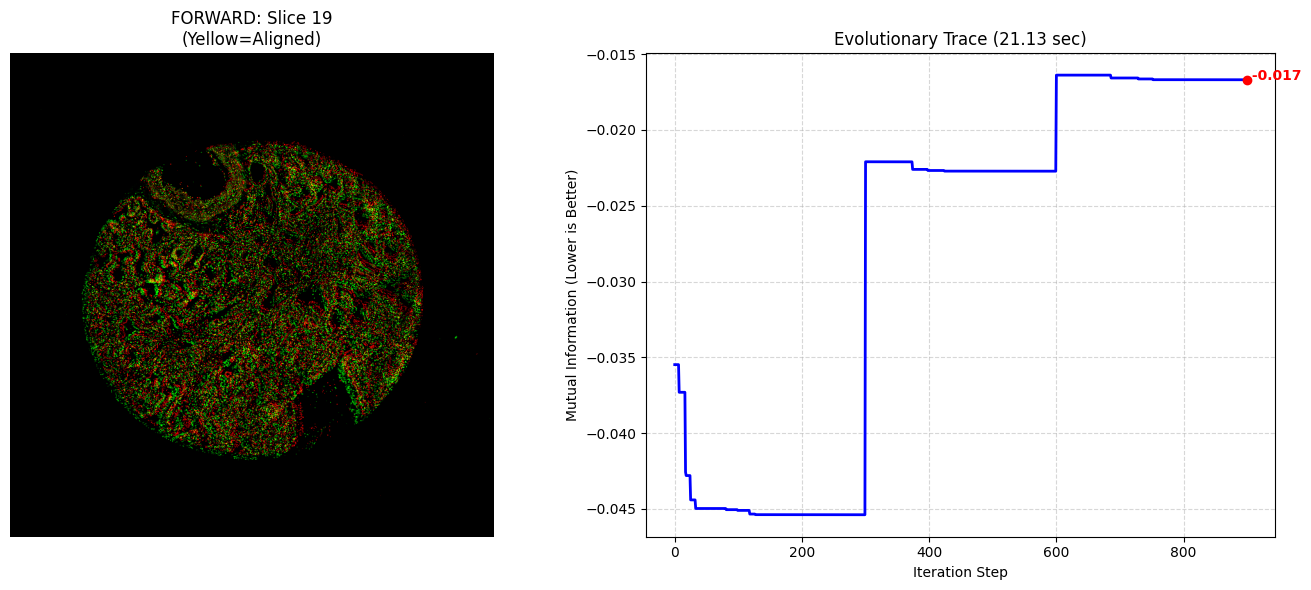

In [6]:

total_slices = len(file_list)
aligned_results = [None] * total_slices
registration_stats = [] 

# Anchor
center_idx = total_slices // 2
center_full = sitk.ReadImage(file_list[center_idx])
aligned_results[center_idx] = center_full
print(f"--- Anchor: Slice {center_idx} ---")

# BACKWARD
print("\n>>> BACKWARD")
current_fixed = center_full
for i in range(center_idx - 1, -1, -1):
    moving = sitk.ReadImage(file_list[i])
    
    # Get Time here
    aligned, metrics, runtime = register_slice_with_metrics(current_fixed, moving)
    
    aligned_results[i] = aligned
    
    final_score = metrics[-1] if metrics else 0
    registration_stats.append({
        "Direction": "Backward",
        "Moving_Slice": i,
        "Fixed_Ref": i + 1,
        "Final_Metric": final_score,
        "Iterations": len(metrics),
        "Runtime(s)": round(runtime, 2) # <--- Save Time
    })
    
    show_dashboard(current_fixed[:,:,0], aligned[:,:,0], metrics, i, "BACKWARD", runtime)
    
    current_fixed = aligned

# FORWARD
print("\n>>> FORWARD")
current_fixed = center_full
for i in range(center_idx + 1, total_slices):
    moving = sitk.ReadImage(file_list[i])
    
    aligned, metrics, runtime = register_slice_with_metrics(current_fixed, moving)
    
    aligned_results[i] = aligned
    
    final_score = metrics[-1] if metrics else 0
    registration_stats.append({
        "Direction": "Forward",
        "Moving_Slice": i,
        "Fixed_Ref": i - 1,
        "Final_Metric": final_score,
        "Iterations": len(metrics),
        "Runtime(s)": round(runtime, 2) # <--- Save Time
    })

    show_dashboard(current_fixed[:,:,0], aligned[:,:,0], metrics, i, "FORWARD", runtime)
    
    current_fixed = aligned

# Evaluate

--- REGISTRATION QUALITY & PERFORMANCE REPORT ---


,Direction,Moving_Slice,Fixed_Ref,Final_Metric,Iterations,Runtime(s)
9,Backward,0,1,-0.002916,900,21.66
8,Backward,1,2,-0.003109,900,20.58
7,Backward,2,3,-0.028205,900,21.40
6,Backward,3,4,-0.023136,900,21.38
5,Backward,4,5,-0.019551,900,21.17
4,Backward,5,6,-0.017668,900,21.03
3,Backward,6,7,-0.032448,900,21.53
2,Backward,7,8,-0.014428,900,21.41
1,Backward,8,9,-0.018979,900,21.46
0,Backward,9,10,-0.015712,900,21.46


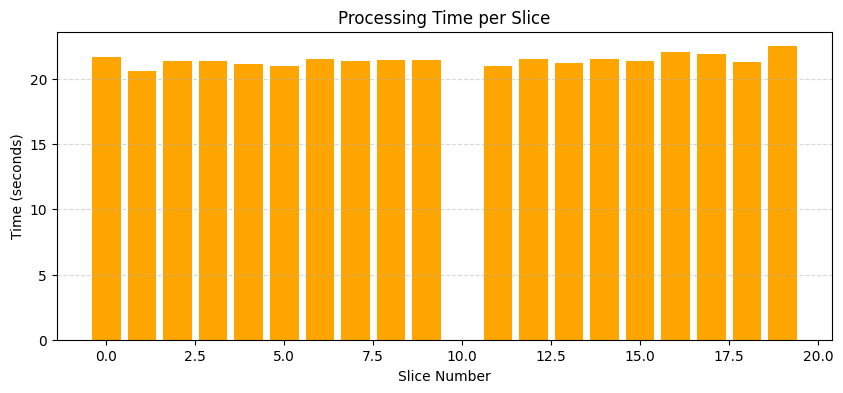

In [47]:
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
# Create DataFrame
df = pd.DataFrame(registration_stats)

# Reorder columns
df = df[["Direction", "Moving_Slice", "Fixed_Ref", "Final_Metric", "Iterations", "Runtime(s)"]]

# Sort by Slice Number
df = df.sort_values(by="Moving_Slice")

print("--- REGISTRATION QUALITY & PERFORMANCE REPORT ---")
try:
    display(df) 
except:
    print(df.to_string(index=False))

# Optional: Plot Performance
plt.figure(figsize=(10, 4))
plt.bar(df["Moving_Slice"], df["Runtime(s)"], color='orange')
plt.title("Processing Time per Slice")
plt.xlabel("Slice Number")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

# Save Result

In [ ]:
output_path = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_CenterOut_Aligned.ome.tif")
print(f"Saving to {output_path}...")

# Filter out any 'None' values just in case
valid_slices = [img for img in aligned_results if img is not None]

# Convert ITK (X,Y,8) -> Numpy (Z, 8, Y, X)
# GetArrayFromImage returns (8, Y, X). Stacking gives (Z, 8, Y, X).
vol = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"Final Volume Shape: {vol.shape}")

tifffile.imwrite(
    output_path, 
    vol, 
    photometric='minisblack',
    metadata={'axes': 'ZCYX'}
)
print("Done.")